<a href="https://colab.research.google.com/github/bekiyeromm/AI_Emotion_Detection/blob/master/newmodel_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

from tensorflow.keras.optimizers import Adam




In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
# Define directories and parameters
# data_dir = '/content/drive/MyDrive/all_typesof_data_format/fer_dataset/RGB'
# data_dir='/content/drive/MyDrive/all_typesof_data_format/fer_dataset/grayscale'
data_dir='/content/clean_data'
# data_dir = '/home/beki/Desktop/research/Research/capsul/datasett/train'
classes = ['happy', 'sad', 'angry','neutral','surprise']
img_size = (128,128)
batch_size = 32

# Function to read and preprocess images
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            img = cv2.medianBlur(img, 5)# apply median filter to reduce noise
            img = cv2.resize(img, img_size, interpolation=cv2.INTER_CUBIC)# Resize image
            img = np.expand_dims(img, axis=-1)  # Add channel dimension
            images.append(img)
            labels.append(label)
    return images, labels





In [46]:
import os
import hashlib

def get_file_checksum(file_path):
    """Returns the MD5 checksum of a file."""
    md5_hash = hashlib.md5()
    with open(file_path, "rb") as f:
        # Read file in chunks to avoid memory issues with large files
        for chunk in iter(lambda: f.read(4096), b""):
            md5_hash.update(chunk)
    return md5_hash.hexdigest()

def find_duplicates(directory):
    """Finds duplicate files in the given directory based on file checksums."""
    checksums = {}
    duplicates = []

    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            checksum = get_file_checksum(file_path)

            if checksum in checksums:
                duplicates.append((file_path, checksums[checksum]))
            else:
                checksums[checksum] = file_path

    return duplicates

# Specify the directory to check for duplicate files
directory_to_check = data_dir

# Find duplicates
duplicate_files = find_duplicates(directory_to_check)

# Output results
if duplicate_files:
    print("Duplicate files found:")
    for dup, original in duplicate_files:
        print(f"{dup} is a duplicate of {original}")
else:
    print("No duplicate files found.")


Duplicate files found:
/content/drive/MyDrive/all_typesof_data_format/fer_dataset/grayscale/surprise/surprise2.png is a duplicate of /content/drive/MyDrive/all_typesof_data_format/fer_dataset/grayscale/surprise/surprise1.png
/content/drive/MyDrive/all_typesof_data_format/fer_dataset/grayscale/surprise/surprise3.png is a duplicate of /content/drive/MyDrive/all_typesof_data_format/fer_dataset/grayscale/surprise/surprise1.png
/content/drive/MyDrive/all_typesof_data_format/fer_dataset/grayscale/surprise/surprise5.png is a duplicate of /content/drive/MyDrive/all_typesof_data_format/fer_dataset/grayscale/surprise/surprise4.png
/content/drive/MyDrive/all_typesof_data_format/fer_dataset/grayscale/surprise/surprise496.jpg is a duplicate of /content/drive/MyDrive/all_typesof_data_format/fer_dataset/grayscale/surprise/surprise224.jpg
/content/drive/MyDrive/all_typesof_data_format/fer_dataset/grayscale/surprise/surprise6.png is a duplicate of /content/drive/MyDrive/all_typesof_data_format/fer_data

In [48]:
import os
import hashlib
import shutil

def get_file_checksum(file_path):
    """Returns the MD5 checksum of a file."""
    md5_hash = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            md5_hash.update(chunk)
    return md5_hash.hexdigest()

def find_and_copy_unique_files(source_directory, destination_directory):
    """Finds unique files in the source directory and copies them to the destination directory with subfolder structure."""
    checksums = {}

    for root, _, files in os.walk(source_directory):
        for file in files:
            file_path = os.path.join(root, file)
            checksum = get_file_checksum(file_path)

            # Only copy unique files based on checksum
            if checksum not in checksums:
                checksums[checksum] = file_path

                # Create the relative subfolder structure in the destination directory
                relative_path = os.path.relpath(root, source_directory)
                dest_folder = os.path.join(destination_directory, relative_path)

                # Create destination folder if it doesn't exist
                if not os.path.exists(dest_folder):
                    os.makedirs(dest_folder)

                # Define the destination file path
                dest_file_path = os.path.join(dest_folder, file)

                # Ensure no overwriting of files with the same name
                if not os.path.exists(dest_file_path):
                    shutil.copy2(file_path, dest_file_path)
                else:
                    base, ext = os.path.splitext(file)
                    count = 1
                    while os.path.exists(dest_file_path):
                        dest_file_path = os.path.join(dest_folder, f"{base}_{count}{ext}")
                        count += 1
                    shutil.copy2(file_path, dest_file_path)

    print(f"Unique files copied to {destination_directory}")

# Define source and destination directories
source_directory = data_dir
destination_directory = "clean_data"

# Find and copy unique files with subfolders
find_and_copy_unique_files(source_directory, destination_directory)


Unique files copied to clean_data


In [13]:
data_dir='/content/rgb_filtered_data'

In [50]:
# dt_source = destination_directory

dt_source=data_dir
import os

def count_files_in_folder(directory):
    """Returns the number of files in the specified directory."""
    file_count = 0
    for root, dirs, files in os.walk(directory):
        file_count += len(files)
    return file_count

# Specify the directory you want to count files in
directory = dt_source

# Get the count of files
file_count = count_files_in_folder(directory)

# Output the result
print(f"There are {file_count} files in the directory {directory}.")


There are 4126 files in the directory /content/clean_data.


In [51]:
# Load images and labels
all_images = []
all_labels = []

for idx, cls in enumerate(classes):
    cls_folder = os.path.join(data_dir, cls)
    images, labels = load_images_from_folder(cls_folder, idx)
    all_images.extend(images)
    all_labels.extend(labels)
# print(all_images.shape)
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Normalize images and ensure they have the correct shape
all_images = all_images.astype('float32') / 255.0

# Split dataset into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    all_images, all_labels, test_size=0.3, random_state=42, stratify=all_labels)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Convert labels to categorical
y_train = to_categorical(y_train, num_classes=len(classes))
y_val = to_categorical(y_val, num_classes=len(classes))
y_test = to_categorical(y_test, num_classes=len(classes))

# Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    'balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = dict(enumerate(class_weights))

# Data augmentation for the training set
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


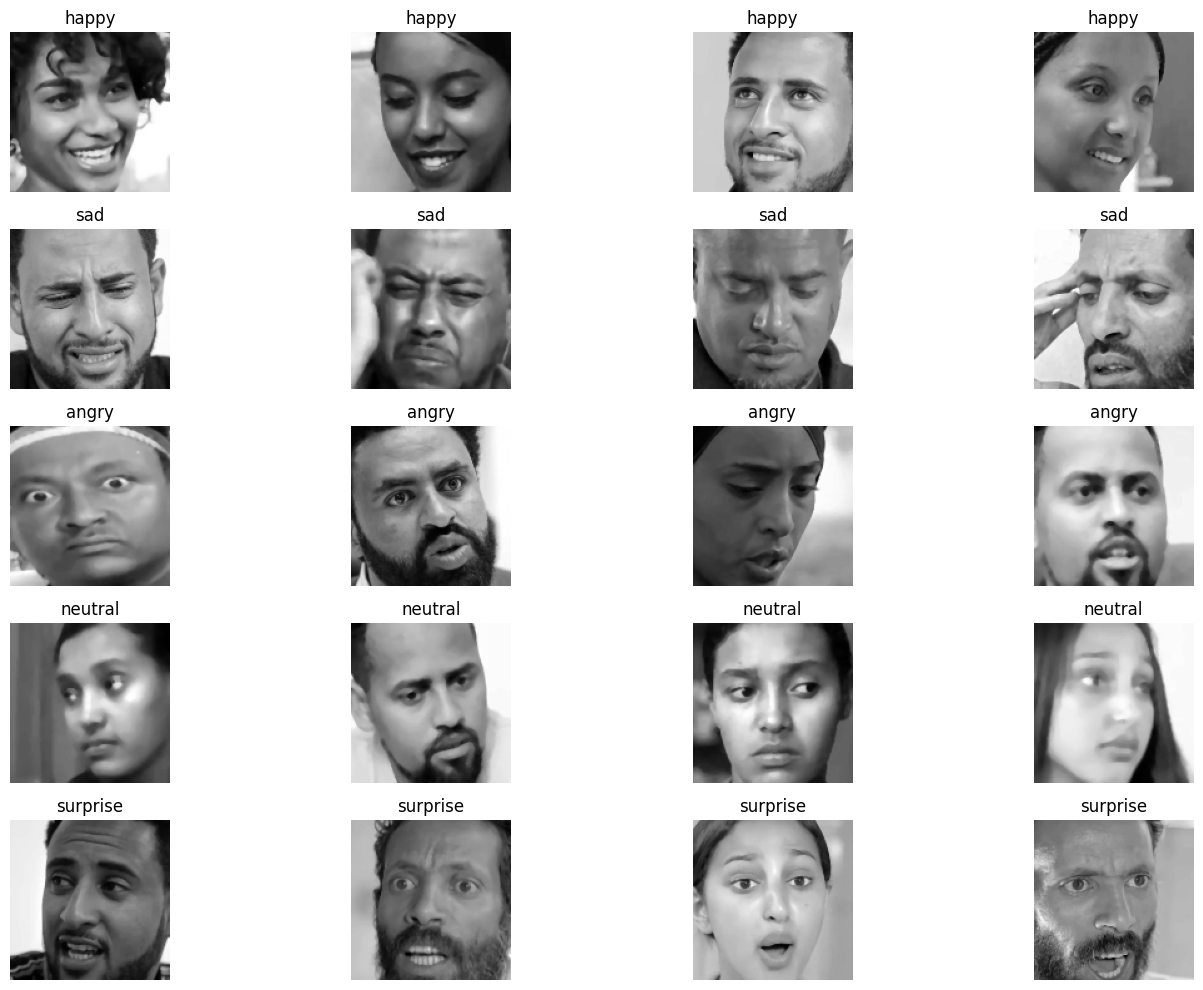

In [52]:

# Display some sample images from each class
def display_sample_images(images, labels, classes, num_samples=4):
    plt.figure(figsize=(15, 10))
    for i, cls in enumerate(classes):
        indices = np.where(labels == i)[0]
        selected_indices = np.random.choice(indices, num_samples, replace=False)
        for j, idx in enumerate(selected_indices):
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(images[idx].squeeze(), cmap='gray')
            plt.title(f'{cls}')
            plt.axis('off')
    plt.tight_layout()
    plt.show()

display_sample_images(all_images, all_labels, classes)

In [109]:


# Define a more complex CNN model
model = Sequential([
    Input(shape=(img_size[0], img_size[1], 1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    # Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    # Dropout(0.1),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    # Dropout(0.1),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    # Dropout(0.1),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    #  Conv2D(256, (3, 3), activation='relu', padding='same'),
    # BatchNormalization(),
    # MaxPooling2D((2, 2)),
    # Dropout(0.3),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(len(classes), activation='softmax')
])


In [110]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_53 (Conv2D)                   │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_45 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_46               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_46 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_55 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_47               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_47 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_56 (Conv2D)                   │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_48 (MaxPooling2D)      │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,781,445 (33.50 MB)

 Trainable params: 8,780,485 (33.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [111]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [113]:

# Early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)  # Adjusted patience and factor
callbacks = [early_stopping, lr_scheduler]


In [114]:
# Train the model using separate validation data

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),  # Experimenting with smaller batch size
    epochs=120,  # Allowing more epochs for better training, early stopping will handle when to stop
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/120


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


181/181 ━━━━━━━━━━━━━━━━━━━━ 26s 68ms/step - accuracy: 0.3089 - loss: 2.6769 - val_accuracy: 0.2924 - val_loss: 3.3968 - learning_rate: 1.0000e-04
Epoch 2/120
181/181 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.4297 - loss: 1.4486 - val_accuracy: 0.3522 - val_loss: 3.4048 - learning_rate: 1.0000e-04
Epoch 3/120
181/181 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.4765 - loss: 1.3394 - val_accuracy: 0.5444 - val_loss: 1.1596 - learning_rate: 1.0000e-04
Epoch 4/120
181/181 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.4767 - loss: 1.2983 - val_accuracy: 0.6074 - val_loss: 1.0199 - learning_rate: 1.0000e-04
Epoch 5/120
181/181 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.5156 - loss: 1.2466 - val_accuracy: 0.5961 - val_loss: 1.0077 - learning_rate: 1.0000e-04
Epoch 6/120
181/181 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.5194 - loss: 1.1884 - val_accuracy: 0.5800 - val_loss: 1.0420 - learning_rate: 1.0000e-04
Epoch 7/120
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accur

In [115]:
# Save the model
model.save('new_model4.h5')

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


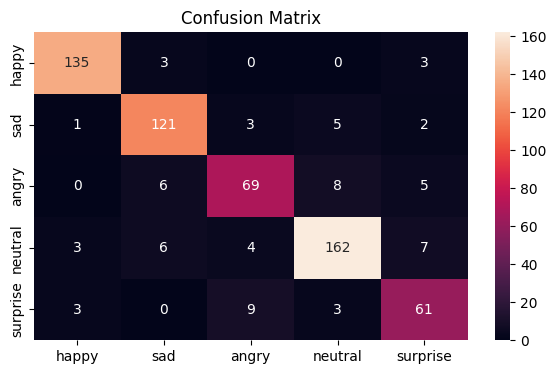

Classification Report:
              precision    recall  f1-score   support

       happy       0.95      0.96      0.95       141
         sad       0.89      0.92      0.90       132
       angry       0.81      0.78      0.80        88
     neutral       0.91      0.89      0.90       182
    surprise       0.78      0.80      0.79        76

    accuracy                           0.89       619
   macro avg       0.87      0.87      0.87       619
weighted avg       0.89      0.89      0.89       619



In [116]:

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(7,4))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=classes))

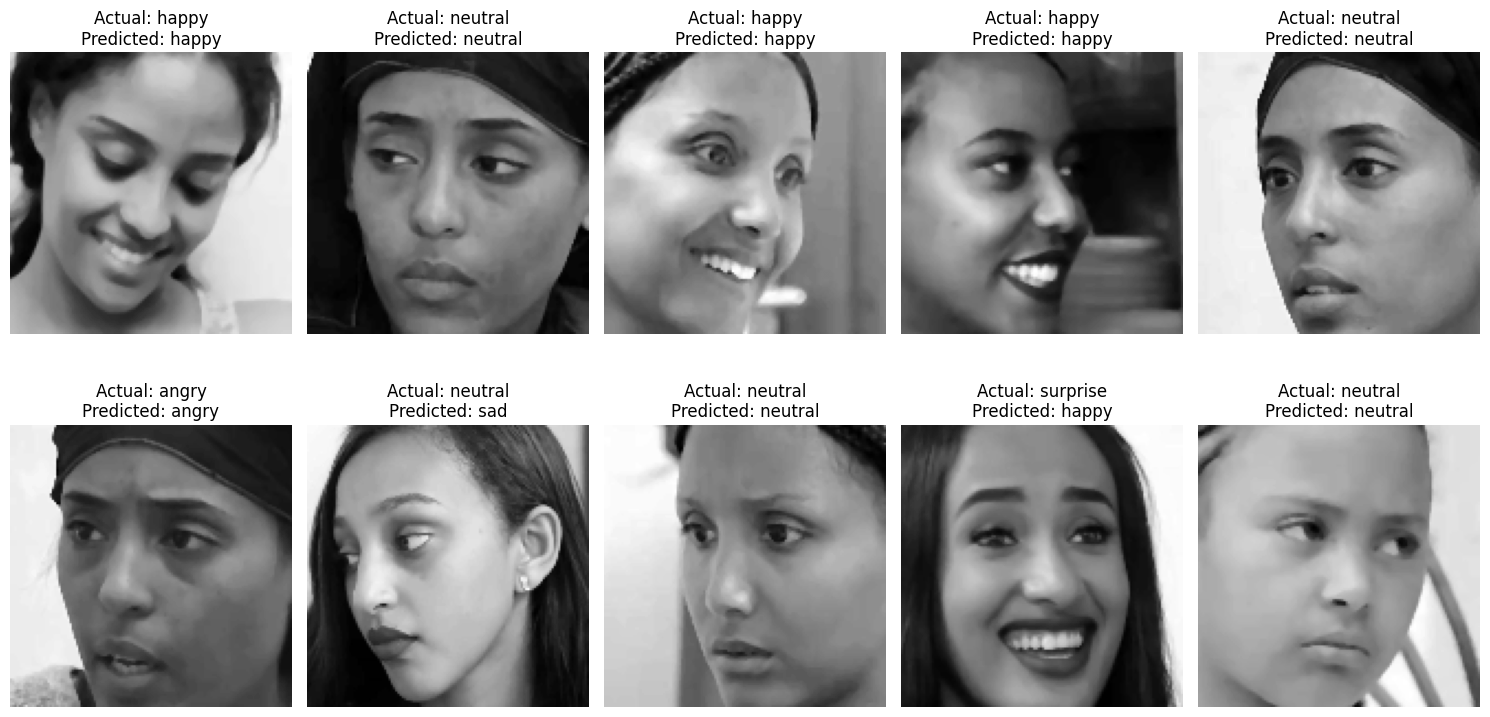

In [117]:
# Function to display a grid of test images with predicted and actual labels
def display_test_images(X_test, y_true, y_pred_classes, classes, num_images=10):
    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_test[i].reshape(X_test.shape[1:]), cmap='gray')  # Assuming grayscale images
        plt.title(f"Actual: {classes[y_true[i]]}\nPredicted: {classes[y_pred_classes[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display 10 test images with actual and predicted labels
display_test_images(X_test, y_true, y_pred_classes, classes, num_images=10)

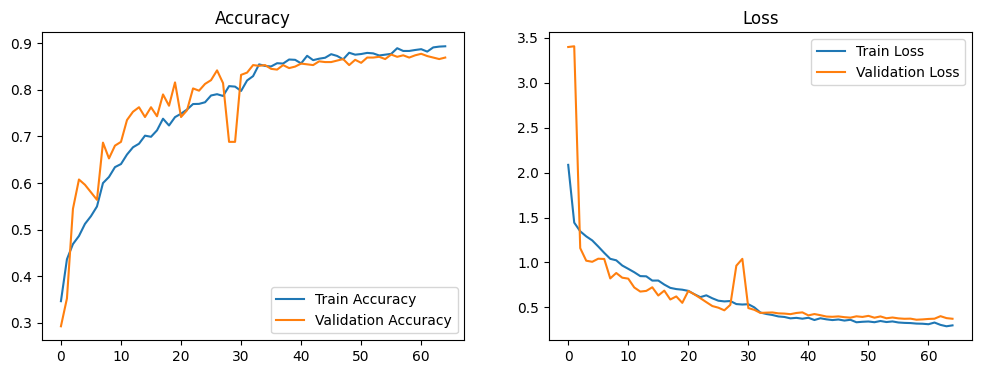

In [118]:

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()
